In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.special import gammaln, logsumexp
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
import arviz as az
from tqdm import tqdm

import sys
sys.path.append("../../../")
from LRM.CMPAR1 import CMPAR1
from LRM.plotting import set_plot_style


set_plot_style()

# downloaded from https://bocsar.nsw.gov.au/statistics-dashboards/open-datasets/criminal-offences-data.html

#FRom this paper: https://academic.oup.com/jrsssc/article/66/4/797/7058304#396903108

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df = pd.read_excel("../../../data/RCI_offencebymonth.xlsm", engine="openpyxl")
df.head()

,LGA,Offence category,Subcategory,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,...,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-11-01 00:00:00,2024-12-01 00:00:00,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00,2025-04-01 00:00:00,2025-05-01 00:00:00,2025-06-01 00:00:00
0,Albury,Homicide,Murder *,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albury,Homicide,Attempted murder,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albury,Homicide,"Murder accessory, conspiracy",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Albury,Homicide,Manslaughter *,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Albury,Assault,Domestic violence related assault,7,7,7,2,7,6,4,...,52,37,46,36,32,57,37,42,38,26


In [3]:
df_ballina = df[df.LGA == "Ballina"].drop("LGA", axis=1)

sex_off_counts_ballina = (df_ballina[df_ballina["Offence category"]
           .isin(["Sexual offences"])]
           .set_index("Offence category")
           .drop("Subcategory", axis=1)
           .T
           .sum(axis=1)
)
print(sex_off_counts_ballina, type(sex_off_counts_ballina))
print(sex_off_counts_ballina.min(), sex_off_counts_ballina.max())

1995-01-01     4
1995-02-01     2
1995-03-01     3
1995-04-01     1
1995-05-01     3
              ..
2025-02-01     9
2025-03-01     9
2025-04-01    14
2025-05-01    12
2025-06-01    20
Length: 366, dtype: int64 <class 'pandas.core.series.Series'>
0 32


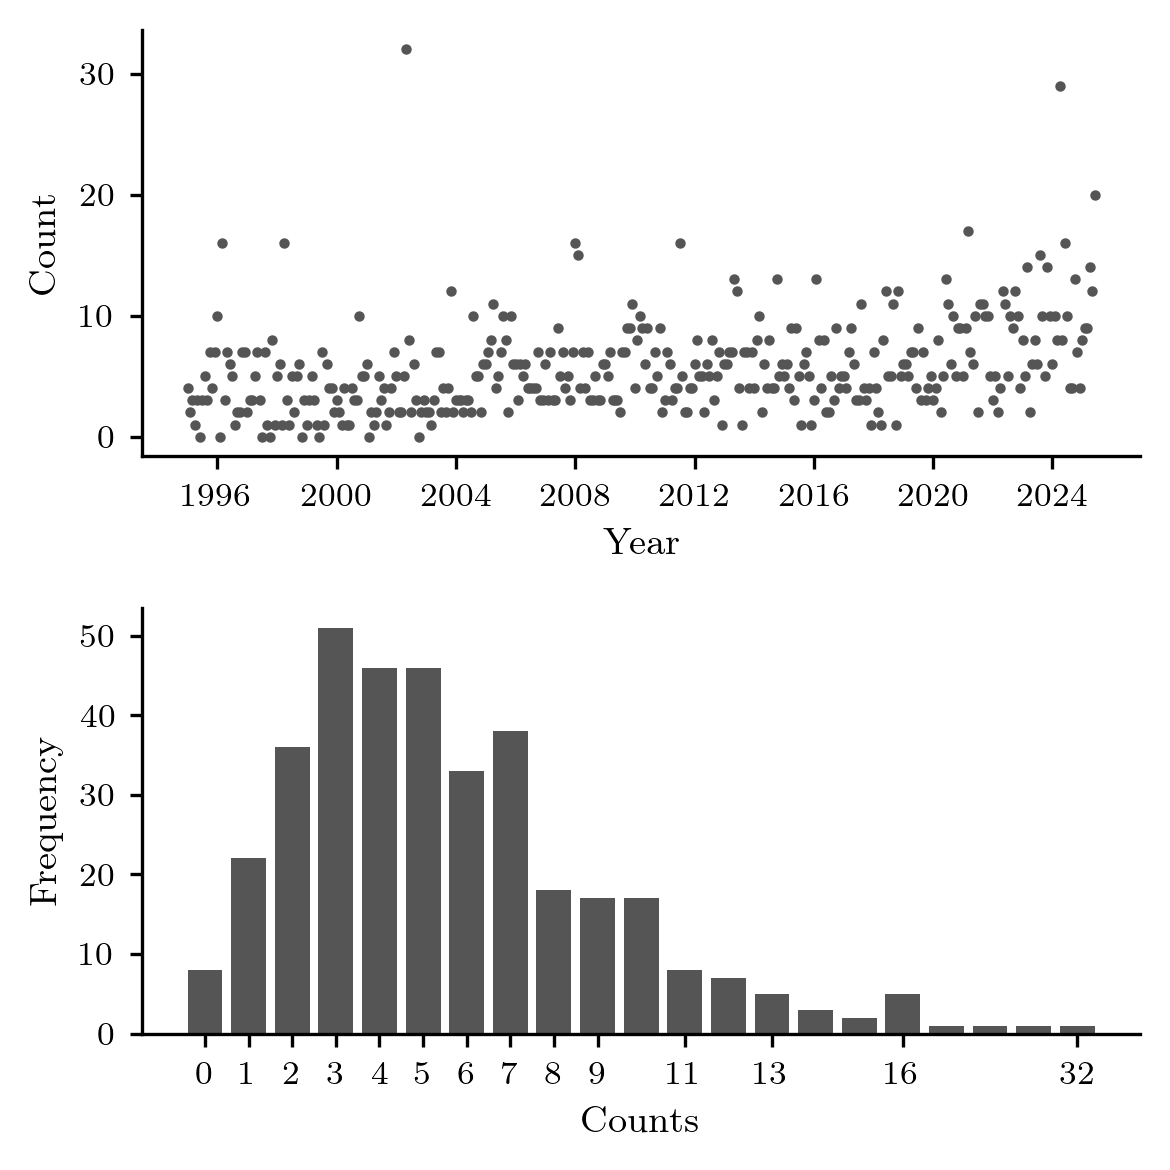

In [4]:
counts = sex_off_counts_ballina

# counts: pandas Series of integer monthly counts (index can be datetime)

# ---- discrete histogram with uniform spacing but skipped labels ----
vc = counts.value_counts().sort_index()
values = vc.index.to_numpy()        # observed integer counts, sorted
freqs  = vc.to_numpy()
pos    = np.arange(len(values))     # categorical, uniform spacing

# choose labels like the paper: all <=9, then a few tail values + max
tail_candidates = [11, 13, 16, values.max()]
tick_pos = []
tick_lab = []
for v in values:
    if v <= 9 or v in tail_candidates:
        tick_pos.append(pos[np.searchsorted(values, v)])
        tick_lab.append(str(v))

fig, axs = plt.subplots(2, 1, figsize=(4,4))

color ='#555555'

# left: time series (optional)
axs[0].plot(counts.index, counts.values, '.', markersize=3, color=color)  # minimal; add counts.index if it's datetime
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Count")


# right: categorical bar chart with skipped labels
axs[1].bar(
    pos,
    freqs,
    facecolor=color,     # transparent fill
    #edgecolor='black',    # black border
    linewidth=1.         # optional: thicker border
)
axs[1].set_xticks(tick_pos, tick_lab)
axs[1].set_xlabel("Counts")
axs[1].set_ylabel("Frequency")
fig.tight_layout()
#fig.savefig("./results/crim-offence-data-plots.pdf", format='pdf', bbox_inches='tight')

## Shared Params

In [6]:
prior_mean = np.ones((3,1)) 
prior_cov = 5 * np.eye(3)
theta_prior = multivariate_normal(mean=prior_mean.flatten(), cov=prior_cov)

## MCMC

In [7]:
def log_p(x, lam, nu):
    """
    Unnormalised CMP model.
    """
    return x * np.log(lam) - nu * gammaln(x + 1)


def log_lam_current(x_prev, log_lam_prev, theta, phi):
    """
    Compute conditional CMP parameter
    """
    return theta[0] + phi * log_lam_prev + theta[1] * np.log(1 + x_prev)


def neg_log_likelihood(samples, theta, phi, k_max=80):
    """
    Conditional negative log-likelihood for CMP-AR(1).
    """
    samples = np.asarray(samples)
    total = 0.0
    n = len(samples)
    log_lams = [np.log(samples.mean())]
    nu = theta[-1]

    for t in range(1, n):
        log_lams.append(
            log_lam_current(samples[t - 1], log_lams[t - 1], theta=theta, phi=phi)
        )
        lam_t = np.exp(log_lams[t])
        log_Z = logsumexp(
            log_p(x=np.arange(0, k_max), lam=lam_t, nu=nu)
        )
        total += log_p(x=samples[t], lam=lam_t, nu=nu) - log_Z

    return -total


def optim_log_lik(samples, phi, x0, bounds, k_max=80):
    """
    Optional: get a good starting point for theta by maximizing the likelihood
    with phi fixed.
    """
    def f(x):
        return neg_log_likelihood(samples, theta=x, phi=phi, k_max=k_max)

    res = minimize(f, x0=x0, bounds=bounds)
    return res.x


def run_mh(
    samples,
    prior_dist,
    phi_init,
    phi_prior_scale=1.0,
    n_steps=5000,
    burnin=3000,
    proposal_cov=None,
    k_max=80,
    theta_init=None,
):
    """
    Plain Metropolis–Hastings over (theta, phi).

    - prior_dist: prior over theta (R^3) with .logpdf(theta)
    - phi_init: initial value for phi
    - phi_prior_scale: std dev of Gaussian prior on phi: N(0, phi_prior_scale^2)
    - proposal_cov: 4x4 covariance matrix for random-walk proposal in (theta, phi).
      If None, use a simple diagonal.
    """

    samples = np.asarray(samples)

    # --- Prior & posterior ---

    def log_prior(theta, phi):
        lp_theta = prior_dist.logpdf(theta)            # 3D prior over theta
        lp_phi = norm(loc=0.0, scale=phi_prior_scale).logpdf(phi)
        return lp_theta + lp_phi

    def log_posterior(theta, phi):
        lp = log_prior(theta, phi)
        if not np.isfinite(lp):
            return -np.inf
        try:
            ll = -neg_log_likelihood(samples, theta=theta, phi=phi, k_max=k_max)
        except Exception:
            return -np.inf
        return lp + ll

    # --- Initial state ---

    ndim = 4  # 3 for theta, 1 for phi

    if theta_init is None:
        # Simple default θ-init; you can replace with MAP via optim_log_lik
        theta_init = np.array([1.0, 0.5, 1.0])

    current_theta = np.asarray(theta_init, dtype=float)
    current_phi = float(phi_init)

    current_log_post = log_posterior(current_theta, current_phi)

    # --- Proposal covariance ---

    if proposal_cov is None:
        # Simple diagonal covariance (tune these scales!)
        proposal_std = np.array([0.015, 0.015, 0.015, 0.008])
        proposal_cov = np.diag(proposal_std**2)
    proposal_cov = np.asarray(proposal_cov, dtype=float)

    # --- Storage ---

    chain = np.zeros((n_steps, ndim))
    acc_count = 0

    # --- MH loop ---

    for t in tqdm(range(n_steps)):
        # Propose a move in 4D: [theta0, theta1, theta2, phi]
        proposal = np.concatenate([current_theta, np.array([current_phi])])
        proposal += multivariate_normal(mean=np.zeros(ndim), cov=proposal_cov).rvs()

        prop_theta = proposal[:3]
        prop_phi = proposal[3]

        prop_log_post = log_posterior(prop_theta, prop_phi)

        log_alpha = prop_log_post - current_log_post
        if np.log(np.random.rand()) <= log_alpha:
            current_theta = prop_theta
            current_phi = prop_phi
            current_log_post = prop_log_post
            acc_count += 1

        chain[t, :3] = current_theta
        chain[t, 3] = current_phi

    accept_rate = acc_count / n_steps
    print(f"MH acceptance rate: {accept_rate:.3f}")

    # Drop burn-in and return
    chain_post = chain[burnin:]

    theta_samples = chain_post[:, :3]
    phi_samples = chain_post[:, 3]

    return theta_samples, phi_samples, chain, accept_rate


def run_mh_multiple_chains(
    samples,
    prior_dist,
    phi_init,
    phi_prior_scale=1.0,
    n_steps=5000,
    burnin=3000,
    proposal_cov=None,
    k_max=80,
    theta_init=None,
    n_chains=4,
    seeds=None,
):
    """
    Run multiple independent MH chains sequentially with tqdm progress bar over chains.
    """
    samples = np.asarray(samples)

    if seeds is None:
        seeds = list(range(n_chains))
    elif len(seeds) != n_chains:
        raise ValueError("len(seeds) must equal n_chains.")

    theta_post_list = []
    phi_post_list = []
    full_chain_list = []
    acc_rates = []

    # Progress bar over chains
    for c in tqdm(range(n_chains), desc="Running MH chains"):
        np.random.seed(seeds[c])

        theta_samps, phi_samps, chain, acc_rate = run_mh(
            samples=samples,
            prior_dist=prior_dist,
            phi_init=phi_init,
            phi_prior_scale=phi_prior_scale,
            n_steps=n_steps,
            burnin=burnin,
            proposal_cov=proposal_cov,
            k_max=k_max,
            theta_init=theta_init,
        )

        theta_post_list.append(theta_samps)
        phi_post_list.append(phi_samps)
        full_chain_list.append(chain)
        acc_rates.append(acc_rate)

    theta_chains_post = np.stack(theta_post_list, axis=0)
    phi_chains_post   = np.stack(phi_post_list, axis=0)
    full_chains       = np.stack(full_chain_list, axis=0)
    acc_rates         = np.asarray(acc_rates)

    return theta_chains_post, phi_chains_post, full_chains, acc_rates



In [8]:
RUN = False
SAVE = False
output_path = "./outputs/mh_full_MCMC_output_chains.npz"

if RUN:

    y = counts.to_numpy()

    theta_chains_post, phi_chains_post, full_chains, acc_rates = run_mh_multiple_chains(
        samples=y,
        prior_dist=theta_prior,
        phi_init=0.1,
        phi_prior_scale=1.0,
        n_steps=100_000,
        burnin=50_000,
        n_chains=4,
        seeds=[123, 456, 789, 101112],  # for reproducibility
    )

    print("Acceptance rates per chain:", acc_rates)
    print("theta_chains_post shape:", theta_chains_post.shape)  # (4, n_post, 3)
    print("phi_chains_post shape:", phi_chains_post.shape)      # (4, n_post)

    if SAVE:
        np.savez(output_path,
                theta_chains_post=theta_chains_post,
                phi_chains_post=phi_chains_post,
                full_chains=full_chains,
                acc_rates=acc_rates)


data_mh = np.load(output_path)
theta_chains_post = data_mh["theta_chains_post"]
phi_chains_post = data_mh["phi_chains_post"]
full_chains = data_mh["full_chains"]
acc_rates = data_mh["acc_rates"]

In [9]:
idata = az.from_dict(
    posterior={
        "theta": theta_chains_post,                 
        "phi":   phi_chains_post[..., np.newaxis],  
    }
)

print("Rhat:")
print(az.rhat(idata))

print("ESS:")
print(az.ess(idata))

Rhat:
<xarray.Dataset> Size: 64B
Dimensions:      (theta_dim_0: 3, phi_dim_0: 1)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 24B 0 1 2
  * phi_dim_0    (phi_dim_0) int64 8B 0
Data variables:
    theta        (theta_dim_0) float64 24B 1.117 1.026 1.028
    phi          (phi_dim_0) float64 8B 1.158
ESS:
<xarray.Dataset> Size: 64B
Dimensions:      (theta_dim_0: 3, phi_dim_0: 1)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 24B 0 1 2
  * phi_dim_0    (phi_dim_0) int64 8B 0
Data variables:
    theta        (theta_dim_0) float64 24B 26.87 166.5 128.4
    phi          (phi_dim_0) float64 8B 21.27


## LRM

In [10]:
def compute_divergence_vectorized(samples, theta, phi, empirical_pmf):
    """
    Vectorized version of the original compute_divergence.
    Returns the same quantity, with the same domain and -inf logic.
    """
    samples = np.asarray(samples)
    n = len(samples)
    assert len(theta) == 3

    nu = theta[-1]

    # ----- 1. Compute log_lams recursively (same AR(1) as original) -----
    log_lams = np.empty(n, dtype=float)
    log_lams[0] = np.log(samples.mean())
    for t in range(1, n):
        log_lams[t] = log_lam_current(
            x_prev=samples[t-1],
            log_lam_prev=log_lams[t-1],
            theta=theta,
            phi=phi
        )

    # We only use t = 1,...,n-1
    x_currs = samples[1:]      # shape (n-1,)
    x_prevs = samples[:-1]     # shape (n-1,)
    log_lams_curr = log_lams[1:]
    lam_curr = np.exp(log_lams_curr)  # shape (n-1,)

    # ----- 2. Build neighbour candidates x_p = x_curr ± 1 -----
    # neighbours[t, 0] = x_curr[t] - 1
    # neighbours[t, 1] = x_curr[t] + 1
    neighbours = np.stack((x_currs - 1, x_currs + 1), axis=1)  # (n-1, 2)

    # Flatten to length 2*(n-1) to make broadcasting easy
    x_p_flat = neighbours.ravel()                      # candidate neighbours
    x_curr_rep_flat = np.repeat(x_currs, 2)            # corresponding x_curr
    x_prev_rep_flat = np.repeat(x_prevs, 2)            # corresponding x_prev
    lam_flat = np.repeat(lam_curr, 2)                  # corresponding λ_t

    # Domain constraint: x_p must be >= 0
    mask_domain = (x_p_flat >= 0)

    # ----- 3. Compute log_ratio_p -----
    # log_p is already vectorized.
    log_p_xp_flat = log_p(x=x_p_flat,     lam=lam_flat, nu=nu)
    log_p_xc_flat = log_p(x=x_curr_rep_flat, lam=lam_flat, nu=nu)
    log_ratio_p_flat = log_p_xp_flat - log_p_xc_flat

    # ----- 4. Compute log_ratio_q via empirical_pmf -----
    # Assume empirical_pmf.score_samples is vectorized over arrays of x, x_prev.
    log_q_xp_flat = empirical_pmf.score_batch_log(x_p_flat,       x_prev_rep_flat)
    log_q_xc_flat = empirical_pmf.score_batch_log(x_curr_rep_flat, x_prev_rep_flat)
    log_ratio_q_flat = log_q_xp_flat - log_q_xc_flat

    # "neginfty constraint": skip if log_ratio_q == -inf, using the same
    # bitwise negation logic as the original: ~np.isneginf(...)
    mask_not_neginf = ~np.isneginf(log_ratio_q_flat)

    # Valid entries must satisfy both constraints
    mask_valid = mask_domain & mask_not_neginf

    # ----- 5. Accumulate total and count exactly as in original -----
    log_ratio_p_valid = log_ratio_p_flat[mask_valid]
    log_ratio_q_valid = log_ratio_q_flat[mask_valid]

    total = np.sum(log_ratio_p_valid**2 - 2.0 * log_ratio_p_valid * log_ratio_q_valid)
    count = np.count_nonzero(mask_valid)

    # This preserves the original behaviour if count == 0
    return (1.0 / count) * total


In [11]:
def LRM_partial_MCMC(
    counts,
    prior_mean,
    prior_cov,
    n_samples=1000,
    scale=0.01,
    n_phi_steps=10,
    phi_init=0.1,
    phi_prior_scale=1.0,
):
    """
    MH-within-Gibbs for (theta, phi) in the CMP AR(1) LRM setup.

    Differences vs original:
      - fit_coverage is called ONCE outside the MCMC (huge speedup).
      - empirical PMF is computed ONCE and reused.
      - A single CMPAR1 object is reused; we just recompute prefix weights and
        (Lambda, nu) for each new phi via its private helpers.
      - compute_divergence_vectorized is used, with cached divergence within
        the inner MH loop for phi.
    """
    # --- Preprocess counts ---
    k_max = int(counts.max()) + 1
    counts = counts.to_numpy()
    alpha = 1.0

    theta_samples = []
    phi_samples = []

    # --- 1) Build a reference CMPAR1 model and calibrate beta ONCE ---
    phi_ref = phi_init
    cmp_ref = CMPAR1(samples=counts, k_max=k_max, alpha=alpha, phi=phi_ref, eps=1e-10)

    # This empirical does NOT depend on phi, we reuse it everywhere
    empirical = cmp_ref.empirical

    # Calibrate beta only once using the reference phi
    beta_hat, cov_hat, _ = cmp_ref.fit_coverage(
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        delta=0.05,
        B=400,
    )

    # For theta-posterior computations, we'll reuse cmp_ref, but overwrite its
    # internal S1, S2, Lambda, nu each iteration as phi changes.

    # --- Initialize phi ---
    phi = phi_init

    # --- 2) Gibbs loop ---
    for _ in tqdm(range(n_samples)):

        # ----- (a) Sample theta | phi using CMPAR1 posterior -----

        # Recompute prefix weights for current phi
        S1, S2 = cmp_ref._prefix_weights(counts, phi)
        cmp_ref._S1, cmp_ref._S2 = S1, S2

        # Recompute (Lambda, nu) for current phi using the fixed empirical PMF
        idx = cmp_ref._t_idx_all
        Lambda_phi, nu_phi = cmp_ref._compute_matrices_from_indices(idx, empirical)
        cmp_ref._Lambda, cmp_ref._nu = Lambda_phi, nu_phi

        # Posterior for theta given current phi and fixed beta_hat
        posterior_mean, posterior_cov = cmp_ref.posterior(
            beta=beta_hat,
            prior_mean=prior_mean,
            prior_cov=prior_cov,
        )

        # Sample theta (use np.random.multivariate_normal to avoid extra overhead)
        theta = np.random.multivariate_normal(
            mean=posterior_mean.ravel(),
            cov=posterior_cov,
        )
        theta_samples.append(theta)

        # ----- (b) Sample phi | theta via MH (within Gibbs) -----

        # Cache divergence at current phi for this theta
        curr_div = compute_divergence_vectorized(
            samples=counts,
            theta=theta,
            phi=phi,
            empirical_pmf=empirical,
        )

        for _ in range(n_phi_steps):
            # Propose new phi (random walk)
            phi_p = np.random.normal(loc=phi, scale=scale)

            # Compute divergence for proposed phi
            prop_div = compute_divergence_vectorized(
                samples=counts,
                theta=theta,
                phi=phi_p,
                empirical_pmf=empirical,
            )

            # Gaussian prior on phi: N(0, phi_prior_scale^2)
            log_prior_curr = norm(loc=0.0, scale=phi_prior_scale).logpdf(phi)
            log_prior_prop = norm(loc=0.0, scale=phi_prior_scale).logpdf(phi_p)

            # log MH ratio (proposal is symmetric, so q cancels)
            log_MH_ratio = (
                -beta_hat * (prop_div - curr_div)
                + (log_prior_prop - log_prior_curr)
            )

            if np.log(np.random.rand()) <= log_MH_ratio:
                phi = phi_p
                curr_div = prop_div  # update cached divergence

        # Store phi after full inner MH step 
        phi_samples.append(phi)

    return np.array(theta_samples), np.array(phi_samples)



def run_LRM_multiple_chains(
    counts,
    prior_mean,
    prior_cov,
    n_chains=4,
    n_samples=5000,
    scale=0.01,
    n_phi_steps=10,
    phi_init=0.1,
    phi_prior_scale=0.01,
    seeds=None,
):
    """
    Runs multiple independent LRM_partial_MCMC chains.
    """

    if seeds is None:
        seeds = list(range(123, 123 + n_chains))
    elif len(seeds) != n_chains:
        raise ValueError("len(seeds) must match n_chains")

    theta_list = []
    phi_list = []

    for c in range(n_chains):
        np.random.seed(seeds[c])
        print(f"Running LRM chain {c+1}/{n_chains} (seed={seeds[c]})...")

        theta_samps, phi_samps = LRM_partial_MCMC(
            counts=counts,
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            n_samples=n_samples,
            scale=scale,
            n_phi_steps=n_phi_steps,
            phi_init=phi_init,
            phi_prior_scale=phi_prior_scale,
        )

        theta_list.append(np.array(theta_samps))   # (n_samples, 3)
        phi_list.append(np.array(phi_samps))       # (n_samples,)

    theta_array = np.stack(theta_list, axis=0)     # (chains, samples, 3)
    phi_array   = np.stack(phi_list,   axis=0)     # (chains, samples)

    return theta_array, phi_array



In [14]:
RUN = False
SAVE = False
output_path = "./outputs/mh_full_LRM_output_chains.npz"

if RUN:
    theta_LRM_run, phi_LRM_run = run_LRM_multiple_chains(
        counts=counts,
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        n_chains=4,
        n_samples=5000,
        scale=0.01,
        n_phi_steps=10,
        phi_init=0.1,
        phi_prior_scale=0.01,
        seeds=[123, 456, 789, 101112],
    )
    if SAVE: 
        np.savez(output_path, theta_LRM=theta_LRM_run, phi_LRM=phi_LRM_run)
else:
    data_LRM = np.load(output_path)
    theta_LRM = data_LRM["theta_LRM"]
    phi_LRM = data_LRM["phi_LRM"]


In [15]:
idata_LRM = az.from_dict(
    posterior={
        "theta": theta_LRM,                    # (chain, draw, 3)
        "phi":   phi_LRM[..., np.newaxis],     # (chain, draw, 1)
    }
)

print("R-hat:")
print(az.rhat(idata_LRM))

R-hat:
<xarray.Dataset> Size: 64B
Dimensions:      (theta_dim_0: 3, phi_dim_0: 1)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 24B 0 1 2
  * phi_dim_0    (phi_dim_0) int64 8B 0
Data variables:
    theta        (theta_dim_0) float64 24B 1.0 1.0 1.0
    phi          (phi_dim_0) float64 8B 1.0


In [20]:
theta_LRM[0].mean(axis=0), theta_LRM[0].std(axis=0)

(array([0.42325398, 0.07688453, 0.34390107]),
 array([0.11006475, 0.05094548, 0.04678904]))